In [2]:
import torch
import torchaudio
import json
import os
import pandas as pd
from tqdm import tqdm
from transformers import Wav2Vec2ForCTC, Wav2Vec2FeatureExtractor
from peft import PeftModel

# --- Configuration ---
CONFIG = {
    "base_model": "facebook/wav2vec2-xls-r-1b",
    "checkpoint_path": "xlsr_lora_1b_best", # Your saved LoRA folder
    "vocab_path": "vocab_1b.json",                    # Your saved Vocab file
    "input_csv": "geo/dev.csv",                   # Input file
    "output_csv": "dev_1bpred.csv",      # Output file
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

def load_resources():
    print(f"Using device: {CONFIG['device']}")
    
    # 1. Load Vocabulary
    if not os.path.exists(CONFIG["vocab_path"]):
        raise FileNotFoundError(f"Vocab file not found at {CONFIG['vocab_path']}. Did you save it during training?")
        
    print("Loading vocabulary...")
    with open(CONFIG["vocab_path"], "r") as f:
        vocab_dict = json.load(f)
    # Create inverse vocab (ID -> Char) for decoding
    inv_vocab = {v: k for k, v in vocab_dict.items()}
    
    # 2. Load Base Model
    print("Loading Base Model...")
    model = Wav2Vec2ForCTC.from_pretrained(
        CONFIG["base_model"], 
        vocab_size=len(vocab_dict),
        pad_token_id=vocab_dict.get("<pad>", 0),
        ignore_mismatched_sizes=True,
        token=False # Force anonymous to avoid 401 errors
    )
    
    # 3. Load LoRA Adapters
    print(f"Loading LoRA Adapters from {CONFIG['checkpoint_path']}...")
    if not os.path.exists(CONFIG["checkpoint_path"]):
        raise FileNotFoundError(f"Checkpoint folder not found at {CONFIG['checkpoint_path']}")
        
    model = PeftModel.from_pretrained(model, CONFIG["checkpoint_path"])
    model.to(CONFIG["device"])
    model.eval()
    
    # 4. Load Processor
    processor = Wav2Vec2FeatureExtractor.from_pretrained(CONFIG["base_model"], token=False)
    
    return model, processor, inv_vocab

def transcribe_single_audio(audio_path, model, processor, inv_vocab):
    """
    Reads audio, resamples, and returns string transcription.
    """
    if not os.path.exists(audio_path):
        return "[ERROR: FILE NOT FOUND]"

    try:
        # Load Audio
        waveform, sr = torchaudio.load(audio_path)
        
        # Resample to 16k if needed
        if sr != 16000:
            waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
        
        # Convert Stereo to Mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Preprocess
        input_values = processor(
            waveform.squeeze().numpy(), 
            sampling_rate=16000, 
            return_tensors="pt"
        ).input_values
        
        input_values = input_values.to(CONFIG["device"])

        # Inference
        with torch.no_grad():
            logits = model(input_values).logits
        
        # Greedy Decode (Argmax)
        pred_ids = torch.argmax(logits, dim=-1)
        pred_ids = pred_ids[0].cpu().tolist()
        
        # Decode to String (CTC Logic)
        pred_str = []
        prev_token = -1
        for token in pred_ids:
            if token != prev_token and token != 0: # 0 is <pad>
                char = inv_vocab.get(token, "")
                # Filter out special tokens just in case
                if char not in ["<s>", "</s>", "<unk>", "<pad>"]:
                    pred_str.append(char)
            prev_token = token
            
        # Join characters and replace pipe with space
        final_text = "".join(pred_str).replace("|", " ")
        return final_text

    except Exception as e:
        return f"[ERROR: {str(e)}]"

def main():
    # 1. Setup Resources
    model, processor, inv_vocab = load_resources()
    
    # 2. Load CSV
    print(f"Reading input CSV: {CONFIG['input_csv']}")
    df = pd.read_csv(CONFIG["input_csv"], delimiter=",")
    
    # Ensure 'transcript' column exists
    if 'transcript' not in df.columns:
        df['transcript'] = ""
    
    # 3. Iterate and Predict
    print(f"Starting inference on {len(df)} files...")
    
    # We iterate through the DataFrame using tqdm for a progress bar
    for index, row in tqdm(df.iterrows(), total=len(df), unit="file"):
        file_path = row['file']
        
        # Generate transcription
        transcription = transcribe_single_audio(file_path, model, processor, inv_vocab)
        
        # Save to DataFrame in memory
        df.at[index, 'transcript'] = transcription

    # 4. Save Results
    print(f"Saving results to {CONFIG['output_csv']}...")
    df.to_csv(CONFIG['output_csv'], index=False)
    print("Done!")

if __name__ == "__main__":
    main()

Using device: cuda
Loading vocabulary...
Loading Base Model...


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-1b and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading LoRA Adapters from xlsr_lora_1b_best...
Reading input CSV: geo/dev.csv
Starting inference on 1000 files...


  0%|                                                                                        | 0/1000 [00:00<?, ?file/s]/m/scicomp/software/scibuilder-mamba/aalto-ubuntu2204/prod/software/scicomp-python-env/2025.2/b4b5f8e/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/m/scicomp/software/scibuilder-mamba/aalto-ubuntu2204/prod/software/scicomp-python-env/2025.2/b4b5f8e/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This depr

Saving results to dev_1bpred.csv...
Done!


Loading data...
Aligning sequences...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13478.49it/s]


Saved to char_confusion_matrix_white_labels.png


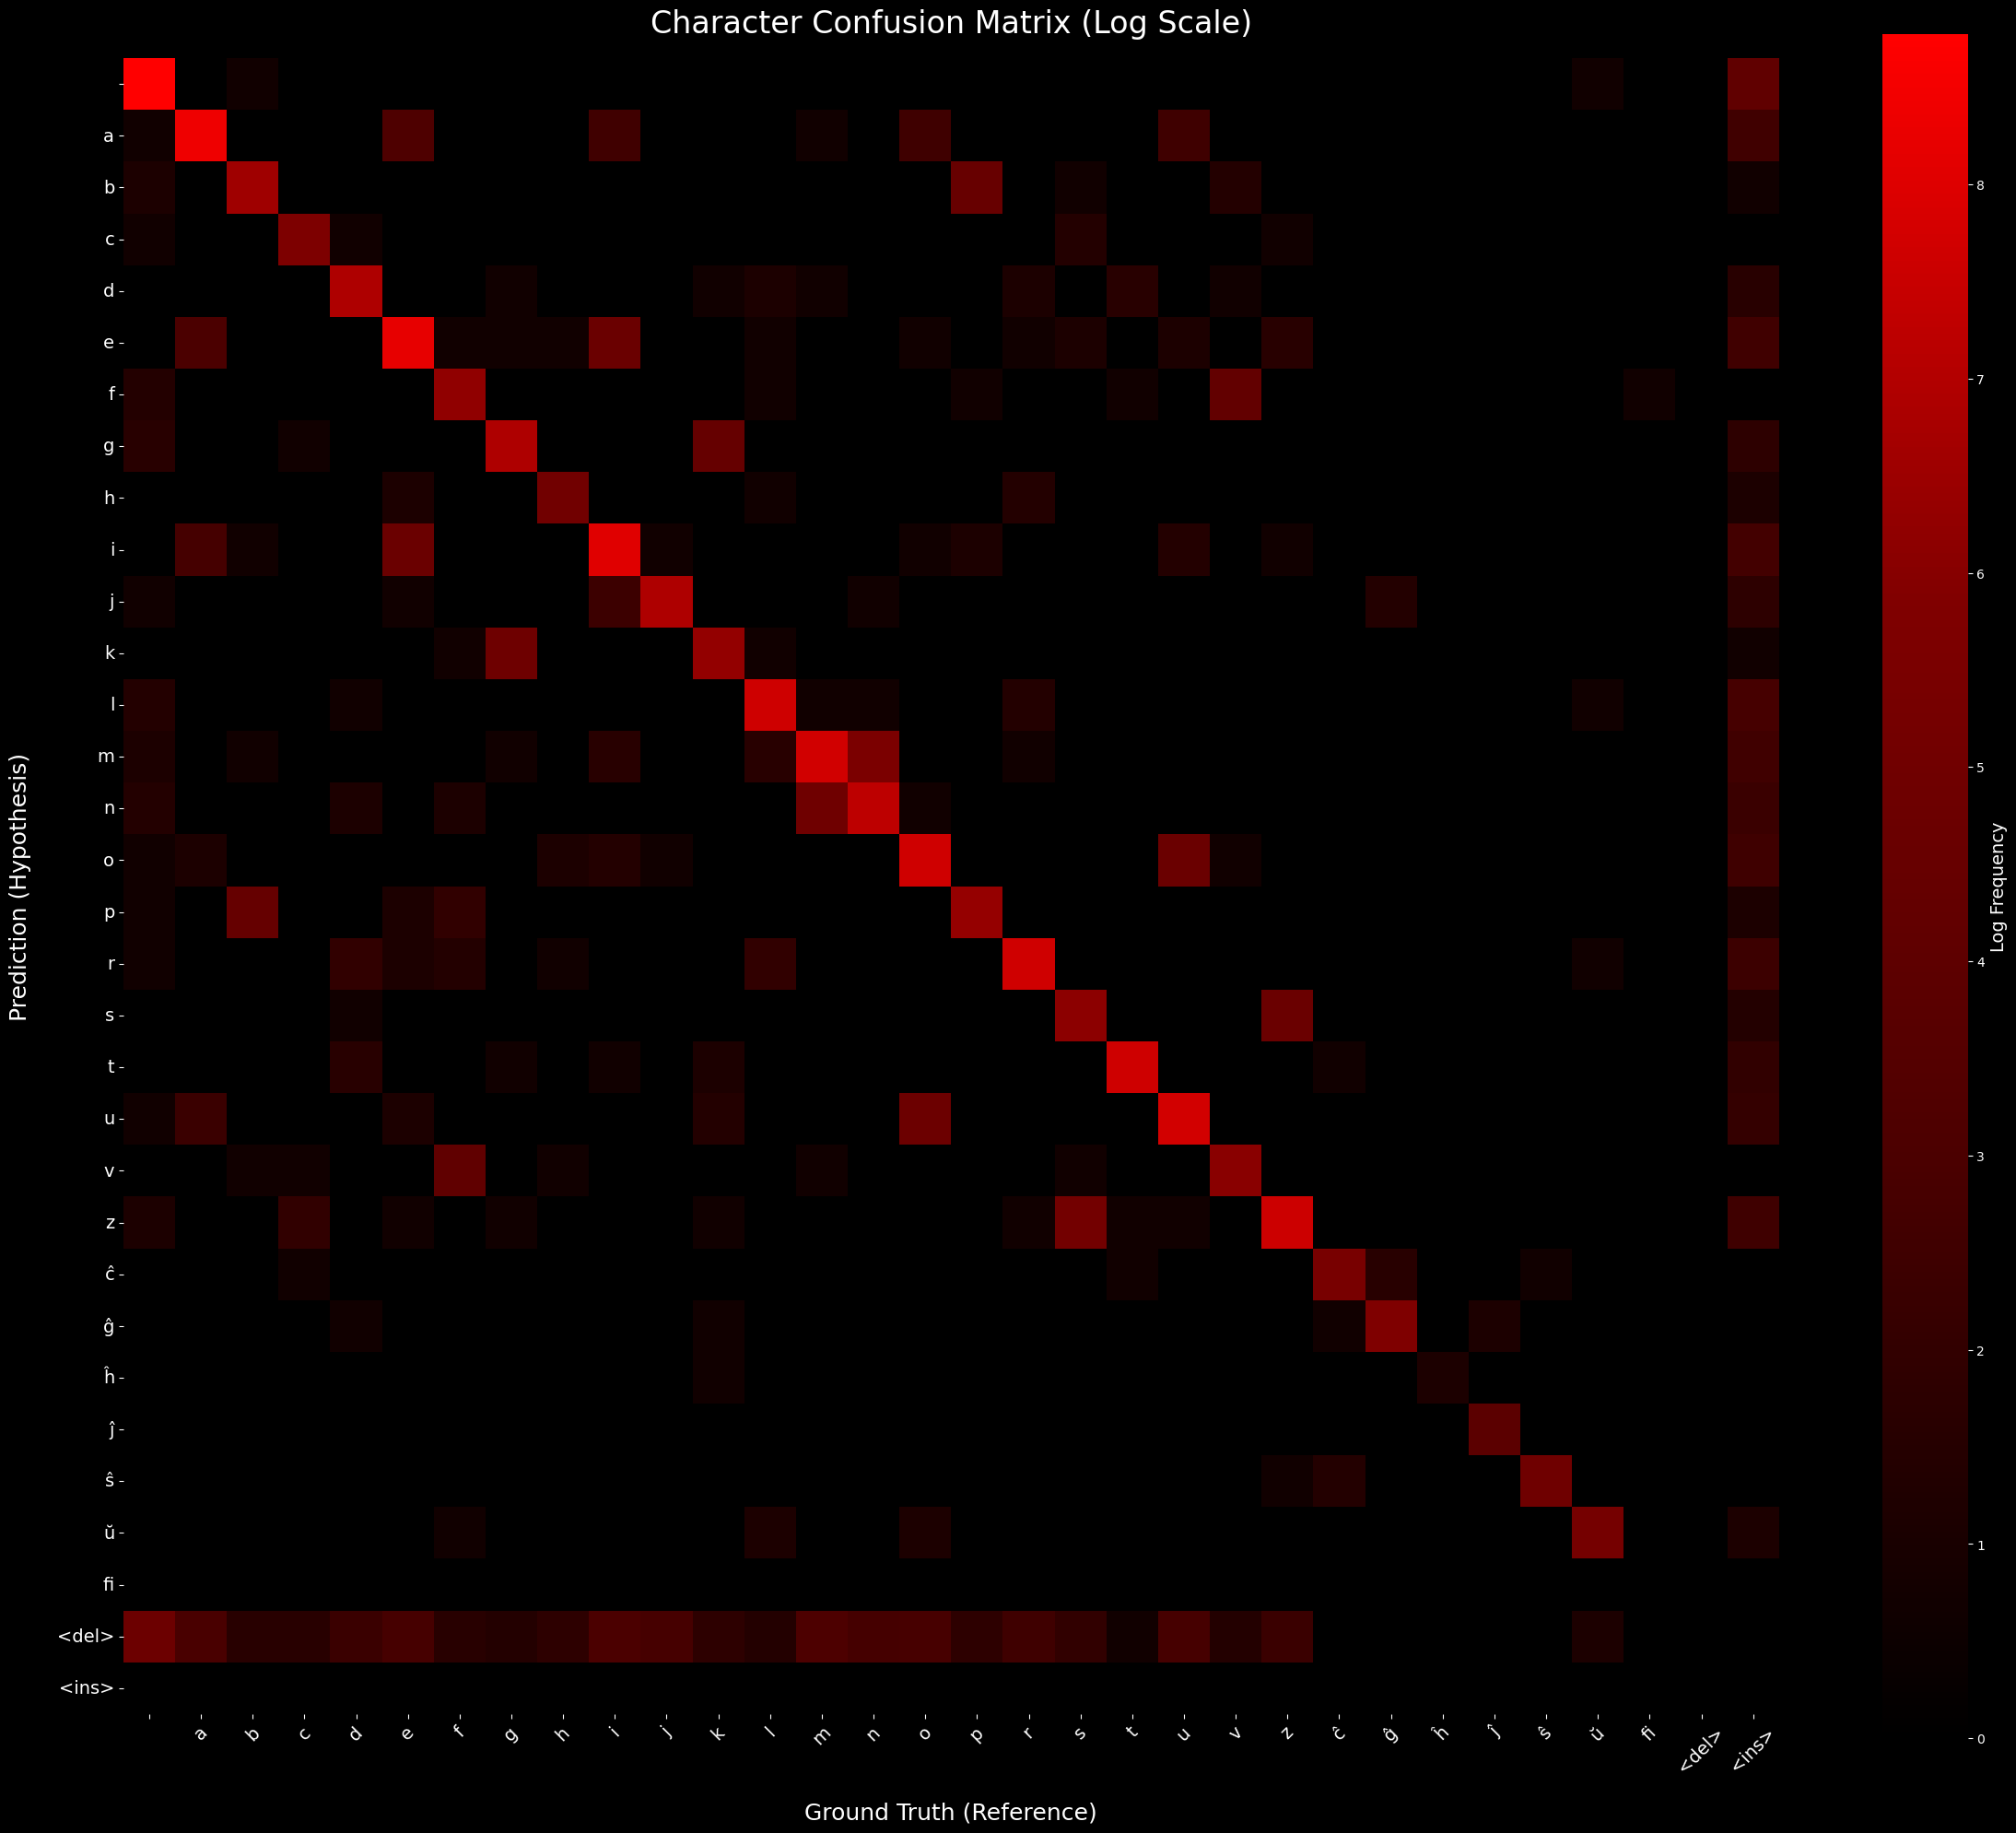

In [11]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import difflib
from tqdm import tqdm
import matplotlib.colors as mcolors

def align_strings(ref, hyp):
    matcher = difflib.SequenceMatcher(None, ref, hyp)
    alignment = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for i in range(i2 - i1):
                alignment.append((ref[i1 + i], hyp[j1 + i]))
        elif tag == 'replace':
            len_ref = i2 - i1
            len_hyp = j2 - j1
            min_len = min(len_ref, len_hyp)
            for i in range(min_len):
                alignment.append((ref[i1 + i], hyp[j1 + i]))
            if len_ref > len_hyp:
                for i in range(min_len, len_ref):
                    alignment.append((ref[i1 + i], '<del>'))
            elif len_hyp > len_ref:
                for i in range(min_len, len_hyp):
                    alignment.append(('<ins>', hyp[j1 + i]))
        elif tag == 'delete':
            for i in range(i2 - i1):
                alignment.append((ref[i1 + i], '<del>'))
        elif tag == 'insert':
            for i in range(j2 - j1):
                alignment.append(('<ins>', hyp[j1 + i]))
    return alignment

def main():
    print("Loading data...")
    try:
        df_gt = pd.read_csv("geo/dev.csv")
        df_pred = pd.read_csv("dev_1bpred.csv")
        with open("vocab_1b.json", "r") as f:
            vocab_map = json.load(f)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return

    df_gt = df_gt.rename(columns={"transcript": "gt_transcript"})
    df_pred = df_pred.rename(columns={"transcript": "pred_transcript"})
    merged_df = pd.merge(df_gt, df_pred, on="file", how="inner")
    
    y_true = []
    y_pred = []

    print("Aligning sequences...")
    for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
        gt = str(row['gt_transcript']).lower()
        pred = str(row['pred_transcript']).lower()
        if not gt or not pred: continue
            
        pairs = align_strings(gt, pred)
        for r_char, p_char in pairs:
            y_true.append(r_char)
            y_pred.append(p_char)

    unique_labels = sorted(list(set(y_true) | set(y_pred)))
    for token in ['<del>', '<ins>']:
        if token in unique_labels:
            unique_labels.remove(token)
            unique_labels.append(token)

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    cm_transposed = cm.T 

    # --- PLOTTING ---
    plt.style.use('dark_background')
    
    fig, ax = plt.subplots(figsize=(24, 20))
    
    # Custom Black-Red Colormap
    colors = ["black", "#4a0000", "#800000", "#ff0000"]
    cmap = mcolors.LinearSegmentedColormap.from_list("DarkRed", colors)

    sns.heatmap(np.log1p(cm_transposed), annot=False, cmap=cmap, ax=ax,
                xticklabels=unique_labels, yticklabels=unique_labels,
                cbar_kws={'label': 'Log Frequency'},
                square=True)

    # Force White Labels
    ax.set_xlabel('Ground Truth (Reference)', fontsize=18, color='white', labelpad=20)
    ax.set_ylabel('Prediction (Hypothesis)', fontsize=18, color='white', labelpad=20)
    ax.set_title('Character Confusion Matrix (Log Scale)', fontsize=24, color='white', pad=20)
    
    # Force White Ticks
    ax.tick_params(axis='x', colors='white', labelsize=14, rotation=45)
    ax.tick_params(axis='y', colors='white', labelsize=14, rotation=0)
    
    # Force White Border (Spines)
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

    # Force Colorbar Labels White
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_tick_params(color='white')
    cbar.set_label('Log Frequency', color='white', fontsize=14)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

    plt.tight_layout()
    plt.savefig('char_confusion_matrix_white_labels.png', dpi=300, facecolor='black', bbox_inches='tight')
    print("Saved to char_confusion_matrix_white_labels.png")
    plt.show()

if __name__ == "__main__":
    main()

<Figure size 640x480 with 0 Axes>